# Rotations

In this notebook, the NN learns learns the 2d rotation matrix, parameterized by the generator of rotations in two dimensions:

$R={\begin{bmatrix}\cos \theta &-\sin \theta \\\sin \theta &\cos \theta \\\end{bmatrix}}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

import torch
import torch.nn as nn
from torch.autograd import Variable

cmap=plt.cm.tab10
c = cycler('color', cmap(np.linspace(0,1,10)))
plt.rcParams["axes.prop_cycle"] = c
plt.style.use('ggplot')

%matplotlib notebook
%matplotlib notebook

In [2]:
%matplotlib notebook

In [ ]:
class Rotations(nn.Module):
    def __init__(self):
        super(Rotations, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(3,1000,bias=True),
            nn.LeakyReLU(),
            nn.Linear(1000,1000,bias=False),
            nn.LeakyReLU(),
            nn.Linear(1000,1000,bias=False),
            nn.LeakyReLU(),
            nn.Linear(1000,1000,bias=False),
            nn.LeakyReLU(),
            nn.Linear(1000,2,bias=False))
        
    def forward(self, x):
        out = self.layer1(x)
        return out

In [3]:
class Rotations(nn.Module):
    def __init__(self):
        super(Rotations, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(3,1000,bias=True),
            nn.LeakyReLU(),
            nn.Linear(1000,2,bias=True))
        
    def forward(self, x):
        out = self.layer1(x)
        return out

In [30]:
models = []
optimizers = []

for k in range(10):
    models.append(Rotations())

for model in models:
    optimizers.append(torch.optim.Adam(model.parameters(),lr=1.0e-3))
    model.cuda()

criterion = nn.SmoothL1Loss()

# torch.save(model.state_dict(), '/scratch/rag394/data/symmetries/rotations.pth')
# model.load_state_dict(torch.load('/scratch/rag394/data/symmetries/rotations.pth'))

In [ ]:
%%time 

num_samples = 10000
for k in range(num_samples):
    
    # =================== data calc ===================
    x = torch.randn(2)
    theta = 2*np.pi*torch.rand(1)
    data = torch.cat((x,theta))
    
    R = torch.zeros(2,2)
    R[0,:] = torch.Tensor([np.cos(theta[0]),-np.sin(theta[0])])
    R[1,:] = torch.Tensor([np.sin(theta[0]), np.cos(theta[0])])

    data, target = Variable(data).cuda(), Variable(torch.mv(R,x)).cuda()
    
    for k,model in enumerate(models):
        # =================== forward =====================
        output  = model(data)
        loss = criterion(output, target)

        # =================== backward ====================
        optimizers[k].zero_grad()
        loss.backward()
        optimizers[k].step()

<IPython.core.display.Javascript object>


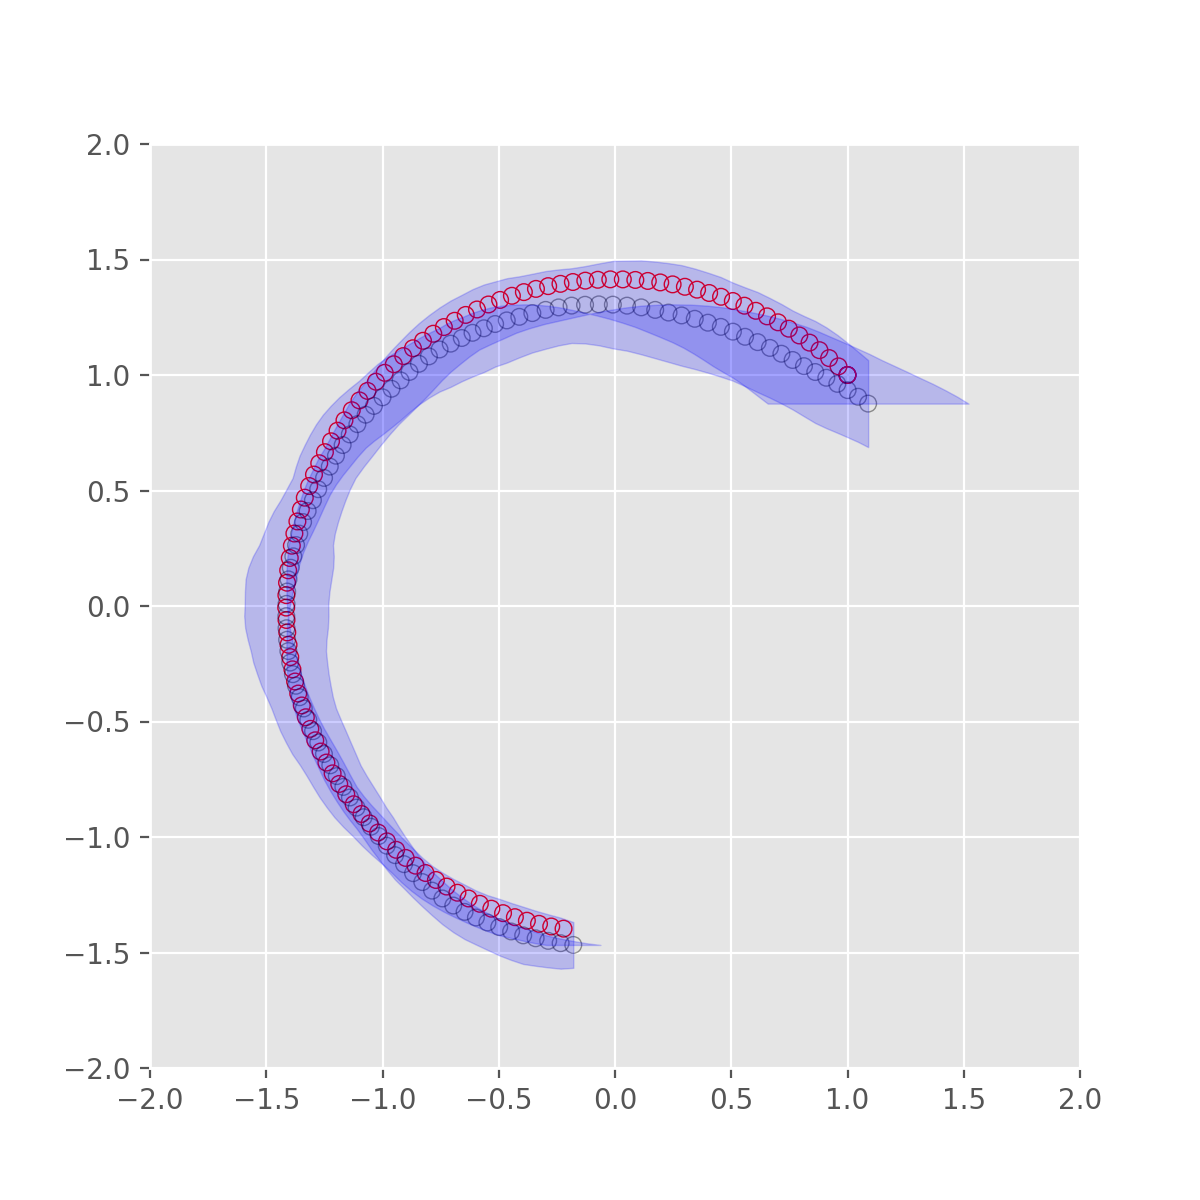

In [51]:
fig, ax = plt.subplots(figsize=(6,6))

x = torch.ones(2)#torch.rand(2)

ax.scatter(x[0],x[1], facecolors='none', edgecolors='r')
ax.scatter(x[0],x[1], facecolors='none', edgecolors='b')

x_real, y_real = [],[]
x_mean, y_mean = [],[]
x_std, y_std = [],[]

for theta in np.linspace(0,1.2*np.pi,100):
    
    data   = Variable(torch.Tensor([x[0],x[1],theta])).cuda()
    
    R = torch.zeros(2,2)
    R[0,:] = torch.Tensor([np.cos(theta),-np.sin(theta)])
    R[1,:] = torch.Tensor([np.sin(theta), np.cos(theta)])

    real = torch.mv(R,x)
    
    x_real.append(real[0])
    y_real.append(real[1])
    
    x_model = []
    y_model = []
    for model in models:
    
        outputs = model(data).data
        xx_model, yy_model = outputs[0],outputs[1]
    
        x_model.append(xx_model)
        y_model.append(yy_model)
    
    x_mean.append(np.mean(x_model))
    y_mean.append(np.mean(y_model))
    
    x_std.append(np.std(x_model))
    y_std.append(np.std(y_model))
    
x_mean,y_mean = np.array(x_mean),np.array(y_mean)
x_std,y_std = np.array(x_std),np.array(y_std)

ax.scatter(x_real,y_real, facecolors='none', edgecolors='r')
ax.scatter(x_mean,y_mean, facecolors='none', edgecolors='k', alpha=0.4)

ax.fill_betweenx(y_mean,x_mean-3*x_std,x_mean+3*x_std, alpha=0.2,color='b')
ax.fill_between(x_mean,y_mean-3*y_std,y_mean+3*y_std,  alpha=0.2,color='b')

ax.set_ylim(-2,2)
ax.set_xlim(-2,2);

In [29]:
list(models[0].parameters())[0].shape

torch.Size([1000, 3])

In [ ]:
W = list(model.parameters())[2].data.cpu().numpy()
W.shape

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))